<a href="https://colab.research.google.com/github/rtajeong/M4_2025/blob/main/lab_61_cats_and_dogs_transfer_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전이학습 고양이 강아지 구분
> - https://subinium.github.io/Keras-5-2/

  - 전이 학습에 많이 사용되는 세 가지 모델은 다음과 같습니다.
  - VGG (예 : VGG16 또는 VGG19).
  - GoogLeNet (예 : InceptionV3).
  - residual Network (예 : ResNet50).
  - 이러한 모델은 성능 때문에 전이 학습  에 널리 사용되지만 VGG (일관성 및 반복 구조), 시작 모듈 (GoogeNet) 및 잔여 모듈 (ResNet)과 같은 특정 아키텍처 혁신을 도입 한 에제임.

- VGG16 (2014)
  - 이미지넷으로 사전 훈련된 네트워크를 사용
  - 1000개의 객체를 구분하는 모델이나, 여기서는 고양이, 강아지 구분에 사용  


## Two different approaches:
-  1) 특성추출 방식 (feature extraction)
  - 합성곱 필터링 영역(convolutional base)를 그대로 사용
  - 공통되는 특성만 추출하여 사용한다
  - 전결합망 부분은 새로운 데이터 (고양이/강아지)로 학습을 다시 시킨다
- 2) 미세 조정 방식 (fine-tuning)
  - 모델 그대로 두고 훈련될 파라미터만 정의 (trainable)
  - 기존 pre-trained model 의 일부도 세부 조정 (훈련) 할 수 있다.
  - 비용이 많이 든다
- 어느 방법이 좋을지는 데이터셋 및 모델 구존에 따라 달라질 수 있음. (Hybrid 방식도 활용 가능)


## ImageDataGenerator() in Keras
- augmentation 은 두 가지 방법에 모두 적용 가능함.
- ImageDataGenerator() 는 original sample 을 뽑아서 그 데이터에 대해 augmentation range 안에서 랜덤하게 image 를 만들어 냄 (original image 도 그 범위에 포함되기 때문에 다른 이미지와 동일한 확률로 발생)
- Original image 를 별도로 추가하면 결과적으로 duplication 이 일어나 overfitting 될 가능성이 있음. Diversity 의 취지에도 맞지 않음.

## Pre-trained model Download

In [ ]:
import os, os.path, shutil
import zipfile
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import VGG16, ResNet101V2

- VGG16으로 사전학습된 가중치 가져오기
  - include_top은 기존의 1000개 전결합망 분류기를 포함할지를 선택

- VGG-16은 ImageNet 데이터베이스의 1백만 개가 넘는 이미지에 대해 훈련된 컨벌루션 신경망입니다.
- 이 네트워크에는 16개의 계층이 있으며, 이미지를 키보드, 마우스, 연필, 각종 동물 등 1,000가지 사물 범주로 분류할 수 있습니다.
- 그 결과 이 네트워크는 다양한 이미지를 대표하는 다양한 특징을 학습했습니다. 네트워크의 이미지 입력 크기는 224x224입니다.

In [ ]:
conv_base = VGG16(weights = 'imagenet',   # loading 할 weights
                 include_top=True,
                 input_shape=(224, 224, 3))

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
conv_base = VGG16(weights = 'imagenet',   # loading 할 weights
                 include_top=False,
                 input_shape=(150, 150, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# Approach 1: 특성 추출 방법 (1)


## 데이터 읽기

In [ ]:
# 더 이상 재공하지 않음 (Kaggle 에서 직접 가져 와야 함)
'''
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

!unzip -q cats_and_dogs_filtered.zip

!apt-get install tree
!tree -d .
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
'''

"\n!curl -L     https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip     -o ./cats_and_dogs_filtered.zip\n\n!unzip -q cats_and_dogs_filtered.zip\n\n!apt-get install tree\n!tree -d .\nbase_dir = './cats_and_dogs_filtered'\ntrain_dir = os.path.join(base_dir, 'train')\nvalidation_dir = os.path.join(base_dir, 'validation')\n"

### 나의 Google Drive 에서 파일 ID 로 다운로드 가능하게 해 놓았음.

In [1]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1WE4cOqgP5Oj5y6ZjSlprWVmfcuChOz4Y"

Downloading...
From (original): https://drive.google.com/uc?id=1WE4cOqgP5Oj5y6ZjSlprWVmfcuChOz4Y
From (redirected): https://drive.google.com/uc?id=1WE4cOqgP5Oj5y6ZjSlprWVmfcuChOz4Y&confirm=t&uuid=c7f90aec-adf3-41d3-be05-129afa096891
To: /content/cat-and-dog.zip
100% 228M/228M [00:01<00:00, 135MB/s]


In [ ]:
import os, shutil, random

# 1. 압축 풀기
!unzip -q cat-and-dog.zip -d ./cats_and_dogs

# 원본 데이터 경로
original_dataset_dir = './cats_and_dogs/training_set/training_set'

# 2. 새로운 베이스 디렉토리 생성
base_dir = './cats_and_dogs_filtered'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

for d in [train_dir, validation_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

for d in [train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir, test_cats_dir, test_dogs_dir]:
    os.makedirs(d, exist_ok=True)

# 3. 파일 리스트 가져오기
cat_files = [f for f in os.listdir(os.path.join(original_dataset_dir, 'cats')) if f.endswith('.jpg')]
dog_files = [f for f in os.listdir(os.path.join(original_dataset_dir, 'dogs')) if f.endswith('.jpg')]

# 섞기
random.shuffle(cat_files)
random.shuffle(dog_files)

# 4. train/validation/test 분리 (예: train 1000, val 500, test 500)
def split_and_copy(files, src_dir, train_dest_dir, val_dest_dir, test_dest_dir, train_size=1000, val_size=500, test_size=500):
    for fname in files[:train_size]:
        shutil.copyfile(os.path.join(src_dir, fname), os.path.join(train_dest_dir, fname))
    for fname in files[train_size:train_size+val_size]:
        shutil.copyfile(os.path.join(src_dir, fname), os.path.join(val_dest_dir, fname))
    for fname in files[train_size+val_size:train_size+val_size+test_size]:
        shutil.copyfile(os.path.join(src_dir, fname), os.path.join(test_dest_dir, fname))

split_and_copy(cat_files, os.path.join(original_dataset_dir, 'cats'), train_cats_dir, validation_cats_dir, test_cats_dir)
split_and_copy(dog_files, os.path.join(original_dataset_dir, 'dogs'), train_dogs_dir, validation_dogs_dir, test_dogs_dir)

print("데이터셋 구조가 과거와 동일하게 생성되었다. ✅")

데이터셋 구조가 과거와 동일하게 생성되었다. ✅


In [ ]:
train_dir

'./cats_and_dogs_filtered/train'

## Feature extraction and define the Model
- 데이터 증식은 사용하지 않음 -> 사용할 수 있음.
- conv_base layers: 일반적인 학습정보
- final FC layers: 특정한 클라스를 분류하는 기능
- ImageDataGenerator를 사용하여 이미지와 레이블을 생성
- conv_base 모델의 predict를 사용하여 이미지의 특성을 추출
- 마지막 출력의 크기가 (4, 4, 512)이다.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
img_width = 150
img_height = 150
batch_size=20

datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # output shape of conv_base
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
                    directory,
                    target_size=(img_width,img_height),
                    class_mode='binary',
                    batch_size=batch_size)

    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)  # get features
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i* batch_size >= sample_count:
            break

    print(features.shape, labels.shape)
    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/s

In [ ]:
train_features.shape, validation_features.shape

((2000, 4, 4, 512), (1000, 4, 4, 512))

- 추출된 특성의 크기는 (samples, 4, 4, 512)입니다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼칩니다:

In [ ]:
train_features = np.reshape(train_features, (2000, 4*4*512))  # 평탄화
validation_features = np.reshape(validation_features, (1000, 4*4*512))

model = models.Sequential()

model.add(layers.Dense(512, activation='relu', input_dim= 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,195,329 (16.00 MB)

 Trainable params: 4,195,329 (16.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    validation_data= (validation_features, validation_labels),
                    batch_size=batch_size)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.6465 - loss: 0.6428 - val_acc: 0.8580 - val_loss: 0.3849
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7934 - loss: 0.4264 - val_acc: 0.8670 - val_loss: 0.3228
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8509 - loss: 0.3275 - val_acc: 0.8800 - val_loss: 0.2972
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8851 - loss: 0.2850 - val_acc: 0.8820 - val_loss: 0.2773
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8896 - loss: 0.2629 - val_acc: 0.8830 - val_loss: 0.2662
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8898 - loss: 0.2509 - val_acc: 0.8860 - val_loss: 0.2581
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9065 - loss: 0.2205 - val_acc: 0.8840 - val_loss: 0.2662
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9225 - loss: 0.1853 - val_acc: 0.8880 - val_loss: 0.2487
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - ac

-  두 개의 Dense 층만 처리하면 되기 떄문에 학습이 매우 빠르다.

## 성능 확인

Text(0.5, 1.0, 'Training(--) and validation loss')

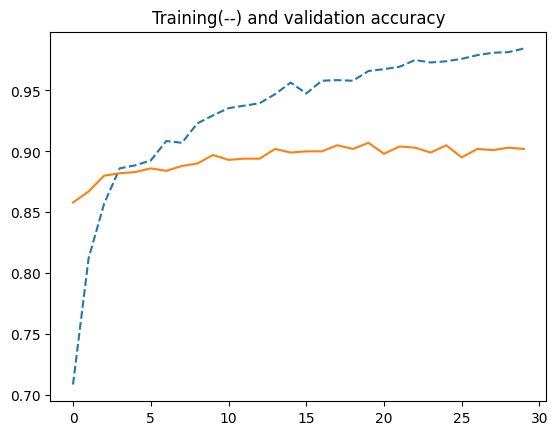

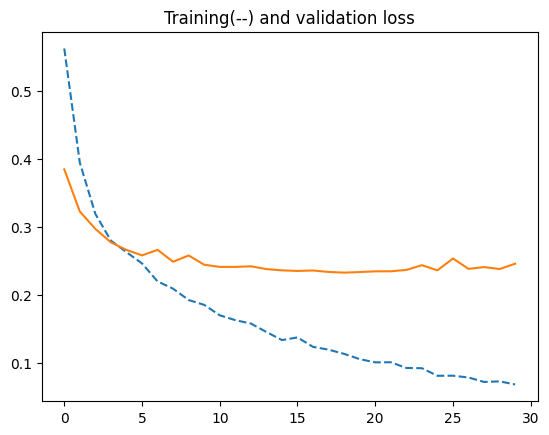

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

- 약 90%의 검증 정확도에 도달했다. 이전에 처음부터 학습시킨 모델 ( 70% 정도)보다 좋지만 데이터 셋이 작기 때문에 과대적합이 발생한 것을 알 수 있다.
  - 훈련 데이터가 부족하다
  - 데이터 확장을 사용하여 개선할 수 있다.

## Augmentation 사용
- Let's try to use Augmetation in Feature-extraction method

Found 2000 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,195,329 (16.00 MB)

 Trainable params: 4,195,329 (16.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.6676 - loss: 0.6021 - val_acc: 0.8700 - val_loss: 0.3005
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.8169 - loss: 0.3993 - val_acc: 0.8810 - val_loss: 0.2672
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.8423 - loss: 0.3542 - val_acc: 0.8880 - val_loss: 0.2526
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.8591 - loss: 0.3206 - val_acc: 0.8940 - val_loss: 0.2407
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8732 - loss: 0.2964 - val_acc: 0.8970 - val_loss: 0.2360
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8812 - loss: 0.2817 - val_acc: 0.8940 - val_loss: 0.2433
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8859 - loss: 0.2653 - val_acc: 0.8940 - val_loss: 0.2402
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8998 - loss: 0.2498 - val_acc: 0.8980 - val_loss: 0.2305
Epoch 9/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ac

Text(0.5, 1.0, 'Training(--) and validation loss')

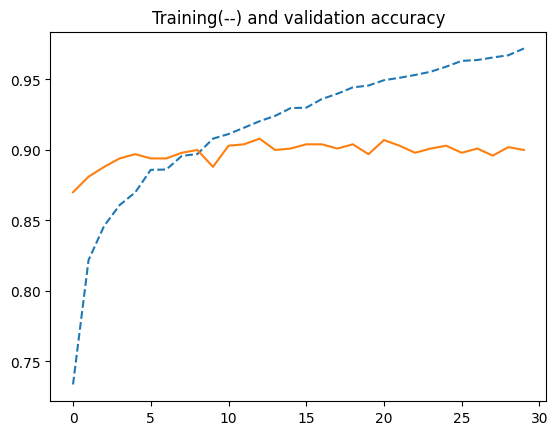

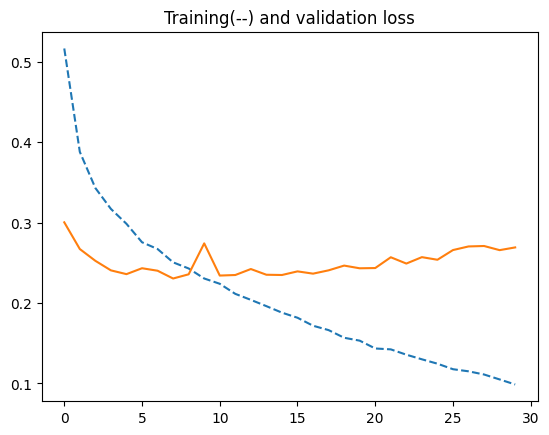

In [ ]:
img_width = 150
img_height = 150
batch_size = 20
Num_aug = 10000  # each of 2000 images is used five times to generate total 10000 fake images

train_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됨.
validation_datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(datagen, directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # output shape of conv_base
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
                    directory,
                    target_size=(img_width,img_height),
                    class_mode='binary',
                    batch_size=batch_size)

    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)  # get features
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i* batch_size >= sample_count:
            break

    # print(features.shape, labels.shape)
    return features, labels

train_features, train_labels = extract_features(train_datagen,
                                                train_dir,
                                                Num_aug)
validation_features, validation_labels = extract_features(validation_datagen,
                                                          validation_dir,
                                                          1000)

print(train_features.shape, validation_features.shape)

train_features = np.reshape(train_features, (Num_aug, 4*4*512))  # 평탄화
validation_features = np.reshape(validation_features, (1000, 4*4*512))

model = models.Sequential()

model.add(layers.Dense(512, activation='relu', input_dim= 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    validation_data= (validation_features, validation_labels),
                    batch_size=batch_size)

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

- 이 경우 성능이 거의 비슷하게 나타났지만, 대부분의 경우 데이터셋이 충분히 크지 않은 경우 Augmentation 을 사용하면 성능이 더 좋아진다.

# Approach 2: 미세조정 방식 (FIne-Tuning) (2)
- conv 모델에 Dense망을 추가하고 학습을 수행
- 데이터 확장을 사용할 수 있다.
- 비용이 많이 든다
- 엔드-투-엔드로 실행한다

In [ ]:
# 모델

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

- 학습을 동결하지 않으면 모두 재 학습된다!

In [ ]:
conv_base.trainable = False
# for layer in conv_base.layers:
#    layer.trainable = False

In [ ]:
print(len(model.trainable_weights))   # 2개의 dense 층 (층마다 w 와 b 텐서)

4


- 컴파일을 수행해야 변경사항이 적용된다

In [ ]:
img_width = 150
img_height = 150
batch_size=20

train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True,
  fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                                directory=train_dir,
								target_size=(img_width,img_height),
								class_mode='binary', # 0 or 1로 labeling
								batch_size=20)

validation_generator = validation_datagen.flow_from_directory(
                                directory=validation_dir,
								target_size=(img_width,img_height),
								class_mode='binary',
								batch_size=20)




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Augmentation with ImageDataGenerator():
- 매 epoch 마다 원래의 이미지에서 생성된 fake image 가 각 한 개씩 만들어져 훈련에 사용된다. (augmented image 는 저장되지 않고 매번 dynamically 만들어짐)
- original image 는 augmented image 를 만들어 낼 때 base 가 되며, 그 자체도 동일한 비율로 사용됨.(starting point for augmentation) 즉, original image 도 augmentation range 에 포함되어 있음.
(별도로 original sample 을 추가해 주면 duplication 결과가 나타나 overfitting 될 가능성도 있음)
- 따라서, 여러 epoch 를 사용하면 size 와 diversity 효과를 냄.


- without/with augmentation 에 의해 train 에 사용되는 이미지를 살펴 보자.

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
2 (20, 150, 150, 3) (20,)


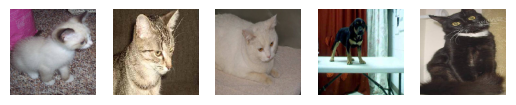

In [ ]:
# for exercise (to see how augmented samples look)

import matplotlib.pyplot as plt

train_datagen = ImageDataGenerator(
  rescale= 1./255,
  #rotation_range = 40,
  #width_shift_range = 0.2,
  #height_shift_range = 0.2,
  #shear_range=0.2,
  #zoom_range=0.2,
  #horizontal_flip = True,
  vertical_flip = True,
  #fill_mode='nearest'
  )

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                                directory=train_dir,
								target_size=(150,150),
								class_mode='binary', # 0 or 1로 labeling
								batch_size=20)

validation_generator = validation_datagen.flow_from_directory(
                                directory=validation_dir,
								target_size=(150,150),
								class_mode='binary',
								batch_size=20)

# non-augmented (즉, original) images
batch = next(validation_generator)
print(len(batch), batch[0].shape, batch[1].shape)

# Display a few images from the batch
for i in range(5):  # Display the first 5 images
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0][i])
    plt.axis('off')
plt.show()

2 (20, 150, 150, 3) (20,)


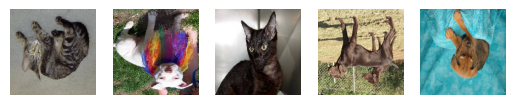

In [ ]:
# Get a batch of images (augmented images)
batch = next(train_generator)
print(len(batch), batch[0].shape, batch[1].shape)

# Display a few images from the batch
for i in range(5):  # Display the first 5 images
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0][i])
    plt.axis('off')
plt.show()  # 원래 이미지도 augmented image 와 동일한 비율로 나타남

- Model define and Train

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])


history = model.fit(
    x=train_generator,
    steps_per_epoch=100,   # epoch 당 batch 갯수
    epochs=60,             # for more (augmented) samples
    validation_data=validation_generator,
    validation_steps=50)

model.save('cats_and_dogs_1.h5')

Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - acc: 0.6056 - loss: 0.6577 - val_acc: 0.8290 - val_loss: 0.4538
Epoch 2/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - acc: 0.7852 - loss: 0.4795 - val_acc: 0.8390 - val_loss: 0.3892
Epoch 3/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - acc: 0.8300 - loss: 0.4098 - val_acc: 0.8560 - val_loss: 0.3500
Epoch 4/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - acc: 0.8432 - loss: 0.3765 - val_acc: 0.8540 - val_loss: 0.3305
Epoch 5/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - acc: 0.8625 - loss: 0.3458 - val_acc: 0.8620 - val_loss: 0.3210
Epoch 6/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - acc: 0.8719 - loss: 0.3210 - val_acc: 0.8730 - val_loss: 0.3056
Epoch 7/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - acc: 0.8872 - loss: 0.2907 - val_acc: 0.8710 - val_loss: 0.3007
Epoch 8/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - acc: 0.8836 - loss: 0.2929 - val_acc: 0.8700 - val_loss: 0.3004
Epoch 9/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s

Text(0.5, 1.0, 'Training(--) and validation loss')

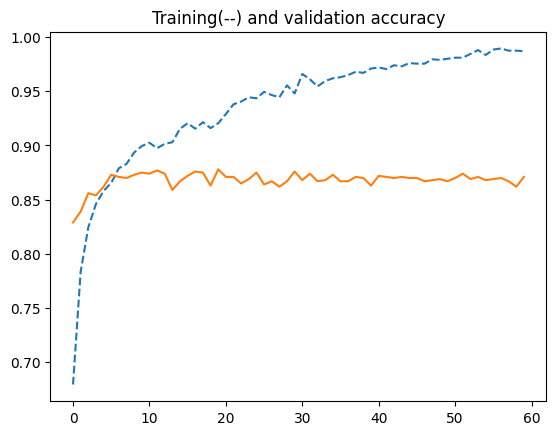

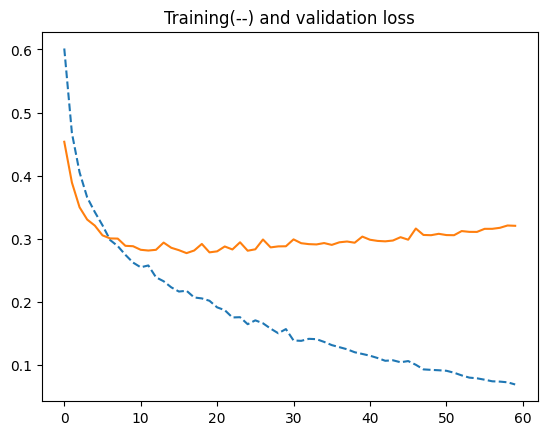

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

- 검증 정확도가 이전과 비슷하지만 처음부터 훈련시킨 소규모 컨브넷보다 과대적합이 줄었다.

# Fine-Tune the Pretrained model (3)
- 모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정이다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것이다.
- 상위 계층 몇개를 재학습시킨다
- 앞에서 소개한 절차, 즉, 전결합망(top)부분을 먼저 학습시킨 후에 상위계층의 미세조정을 해야 한다 (한번에 학습하면 안되고 두 단계로 나누어야 함)
 - (1)기존 네트워크 상단에 새로운 네트워크 추가한다.
 - (2) 기본 네트워크를 고정시킨다.
 - (3) 새로 추가한 부분을 훈련시킨다.
 - (4) 기본 계층 중에 학습할 상위 부분의 고정을 푼다.
 - (5) 고정을 푼 계층과 새로 추가한 계층을 함께 훈련시킨다.
- 이미 (3) 까지는 전 단계 예제에서 특성 추출할 때 이미 수행이 되어 있기 떄문에 여기서는 (4) 번쨰 단계부터 실행하기만 하면 된다.

         

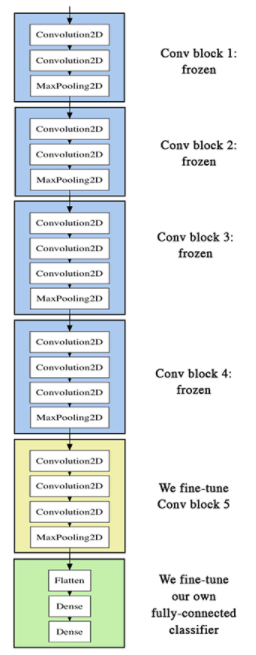

In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### 위에서 block 5 부분만 미세조정 하겠다

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


### 학습률을 작게 조정한다 (천천히 학습하도록)
- 미세 조정하는 층에서 학습된 표현을 조금씩 수정하기 위해

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

# Re-initialize conv_base with the correct input shape for 150x150 images
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Re-define the model with the correctly shaped conv_base
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Ensure the conv_base layers are set to not trainable as intended for this approach
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(
    x=train_generator,
    steps_per_epoch=100,
    epochs=60,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - acc: 0.6969 - loss: 0.5813 - val_acc: 0.8670 - val_loss: 0.3456
Epoch 2/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - acc: 0.8443 - loss: 0.3647 - val_acc: 0.8890 - val_loss: 0.2817
Epoch 3/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - acc: 0.8780 - loss: 0.2917 - val_acc: 0.8890 - val_loss: 0.2603
Epoch 4/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - acc: 0.9020 - loss: 0.2223 - val_acc: 0.8960 - val_loss: 0.2576
Epoch 5/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - acc: 0.9175 - loss: 0.1879 - val_acc: 0.9060 - val_loss: 0.2282
Epoch 6/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - acc: 0.9481 - loss: 0.1472 - val_acc: 0.9010 - val_loss: 0.2296
Epoch 7/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - acc: 0.9591 - loss: 0.1330 - val_acc: 0.9030 - val_loss: 0.2410
Epoch 8/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - acc: 0.9687 - loss: 0.1082 - val_acc: 0.8950 - val_loss: 0.2618
Epoch 9/60
100/100 ━━━━━━━━━━━━━

Text(0.5, 1.0, 'Training(--) and validation loss')

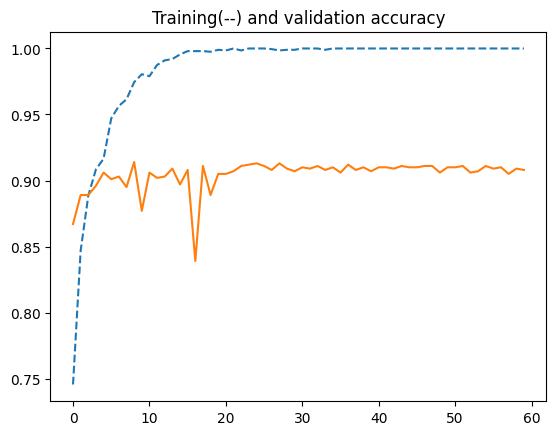

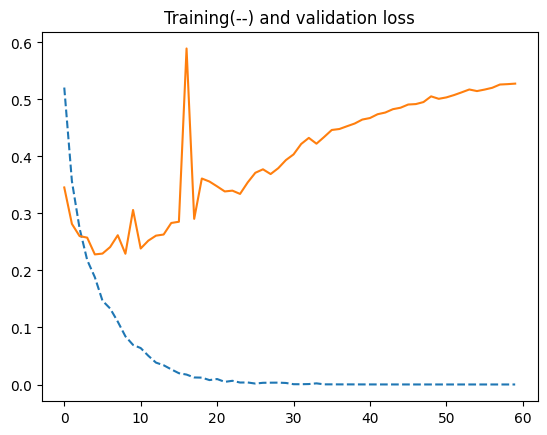

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

## 성능이 92-94%로 1% 정도 향상되었다.
- 주의 할 것은 손실함수는 향상되지 않는 것으로 나타나도, 성능이 향상될 수 있다는 것이다. (분류 성능은 어떤 임계값만 넘으면 활률적으로 개선될 수 있다)
- 정확도에 영향을 미치는 것은 손실값의 분포이지 평균이 아님.
- 지금까지 전체 캐글 경연 데이터의 10%인 2000 개만 사용해서도 높은 성능 결과 얻음.

## 요약
- 과대적합을 줄이기 위해서 데이터 확장을 사용
- 전이학습 중 특성 추출방식 소개
- 전이학습 중 미세조정 방식 소개

# Exercise (연습)

## How to Visualize Filters
- https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [ ]:
# load vgg model
from keras.applications.vgg16 import VGG16
model = VGG16()
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# summarize filters in each convolutional layer
from tensorflow.keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
model = VGG16()

for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


In [ ]:
model.layers[0].get_weights(), model.layers[1].get_weights()

([],
 [array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
            -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
           [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
            -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
           [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
            -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
  
          [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
            -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
           [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
            -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
           [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
            -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
  
          [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
            -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
           [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, 

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()

In [ ]:
filters.shape

(3, 3, 3, 64)

In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

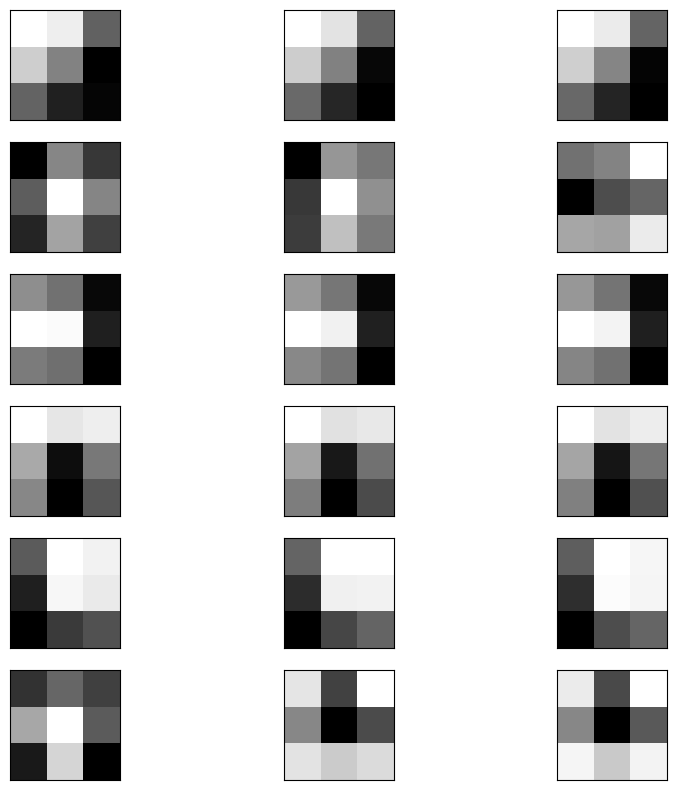

In [ ]:
# plot first few filters
plt.figure(figsize=(10,10))
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

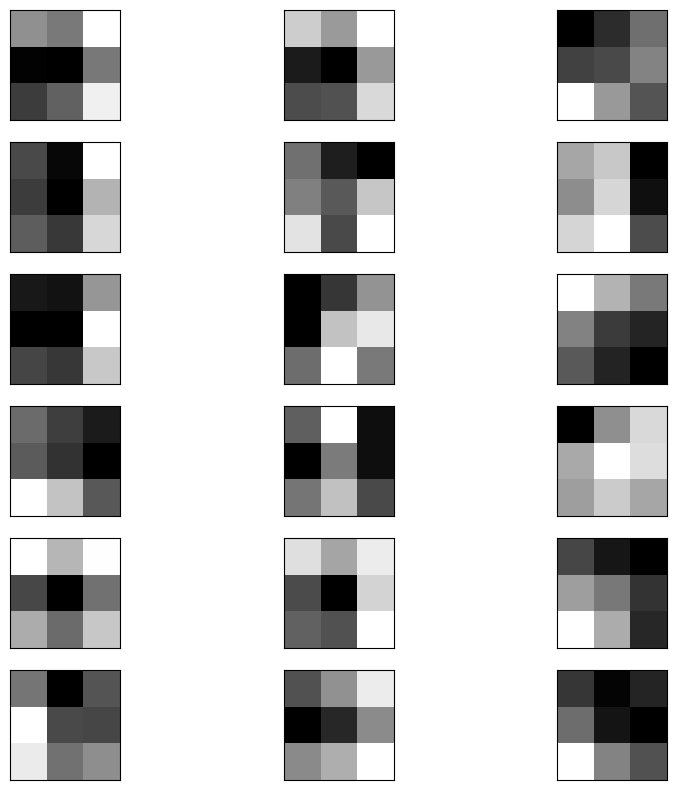

In [ ]:
# 10-th layer filters
filters, biases = model.layers[9].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
plt.figure(figsize=(10,10))
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

## How to Visualize Feature maps
- refer to lab60 for feature maps of the cats_and_dogs example code
- here we have another example

In [ ]:
# summarize feature map size for each conv layer
from tensorflow.keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
model = VGG16()
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [ ]:
# redefine model to output right after the first hidden layer
model = models.Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
# load the image with the required shape
from keras.preprocessing.image import load_img
img = load_img('bird.jpg', target_size=(224, 224))

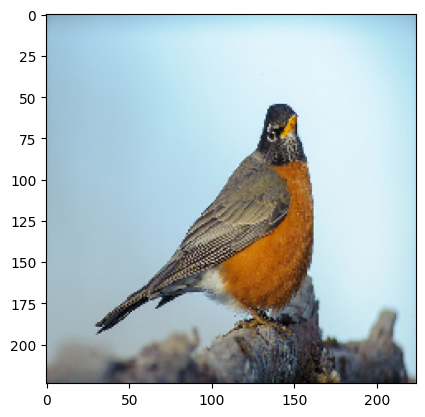

In [ ]:
plt.imshow(img)

In [ ]:
# convert the image to an array
img = image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)

In [ ]:
# prepare the image (e.g. scale pixel values for the vgg)
from keras.applications.vgg16 import preprocess_input
img = preprocess_input(img)

In [ ]:
# get feature map for first hidden layer
feature_maps = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


In [ ]:
feature_maps.shape

(1, 224, 224, 64)

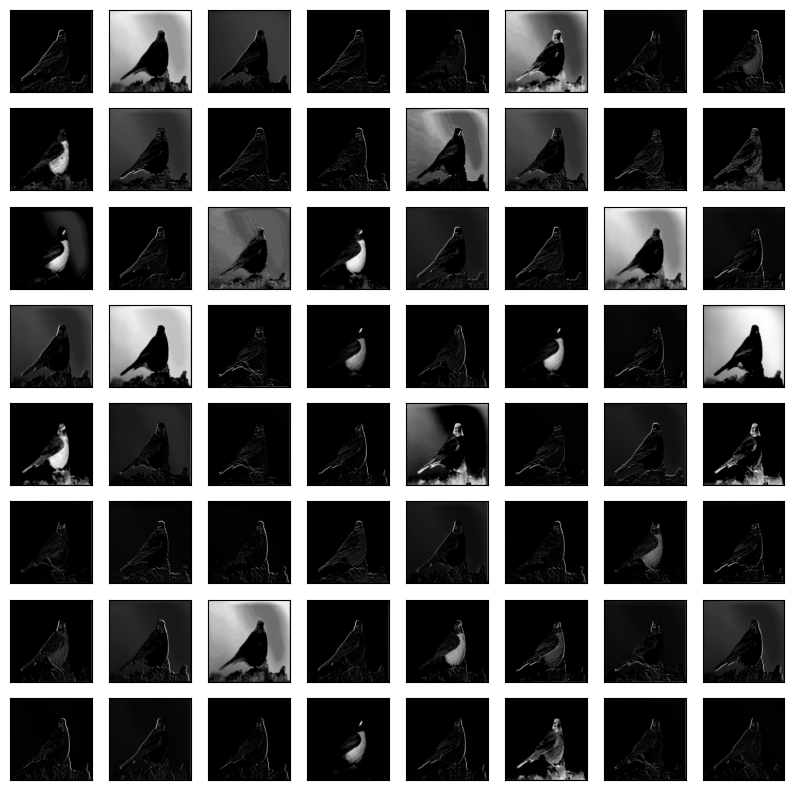

In [ ]:
# plot all 64 maps in an 8x8 squares
plt.figure(figsize=(10,10))
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,720 (151.25 KB)

 Trainable params: 38,720 (151.25 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


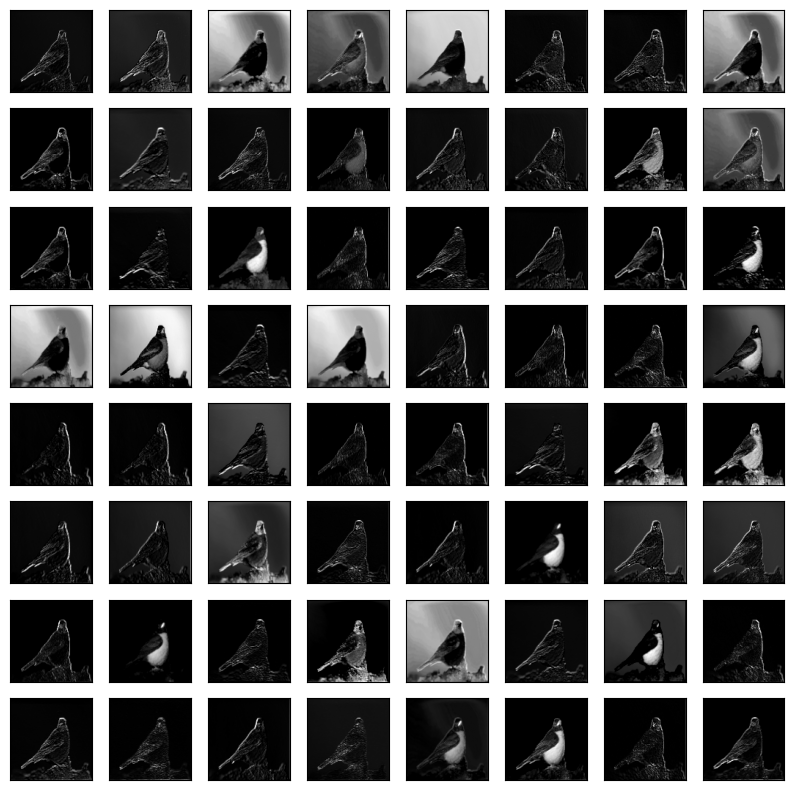

In [ ]:
# All together
# plot feature map of third conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[3].output)
model.summary()
# load the image with the required shape
img = load_img('bird.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(10,10))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,488 (6.62 MB)

 Trainable params: 1,735,488 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


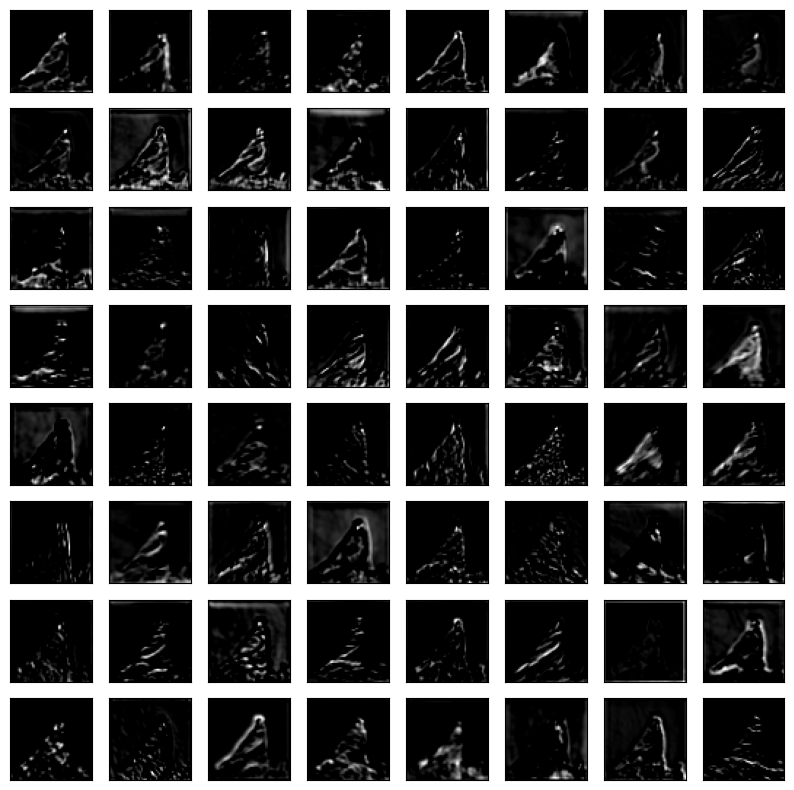

In [ ]:
# after 10-th layer
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[9].output)
model.summary()
# load the image with the required shape
img = load_img('bird.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(10,10))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [ ]:
VGG16().layers

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


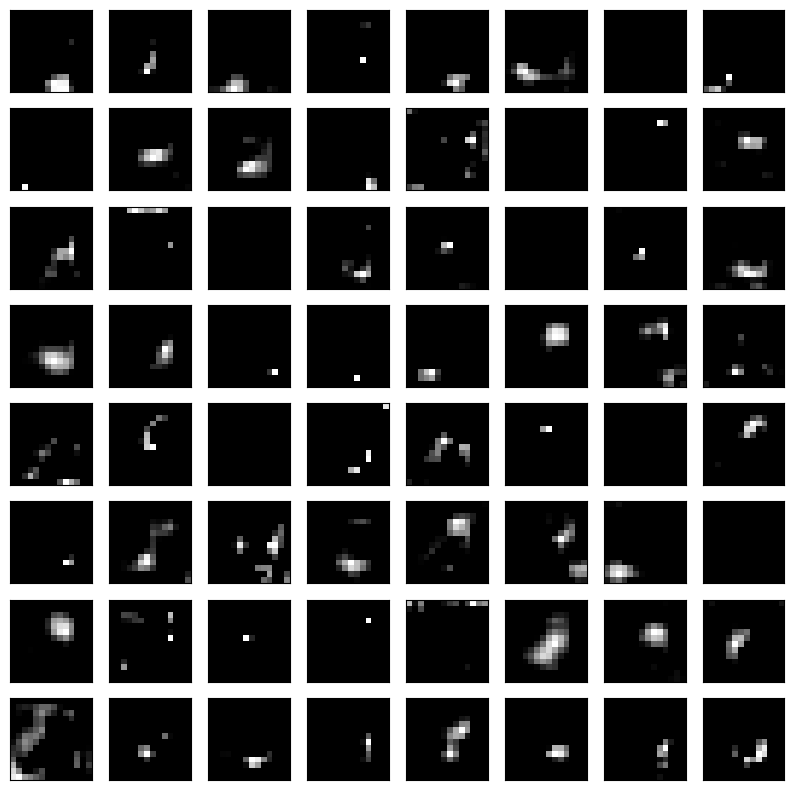

In [ ]:
# after 17-th layer
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[17].output)
model.summary()
# load the image with the required shape
img = load_img('bird.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(10,10))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

- We can see that the result of applying the filters in the first convolutional layer is a lot of versions of the bird image with different features highlighted.
- For example, some highlight lines, other focus on the background or the foreground.

## another approach
- collect feature maps output from each block of the model in a single pass, then create an image of each.
- There are five main blocks in the image (e.g. block1, block2, etc.) that end in a pooling layer. The layer indexes of the last convolutional layer in each block are [2, 5, 9, 13, 17].
- We can define a new model that has multiple outputs, one feature map output for each of the last convolutional layer in each block.
- we can now create five separate plots for each of the five blocks in the VGG16 model for our bird photograph.

In [ ]:
model = VGG16()
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# visualize feature maps output from each block in the vgg model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('bird.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


In [ ]:
len(feature_maps)

5

In [ ]:
[i.shape for i in feature_maps]

[(1, 224, 224, 64),
 (1, 112, 112, 128),
 (1, 56, 56, 256),
 (1, 28, 28, 512),
 (1, 14, 14, 512)]

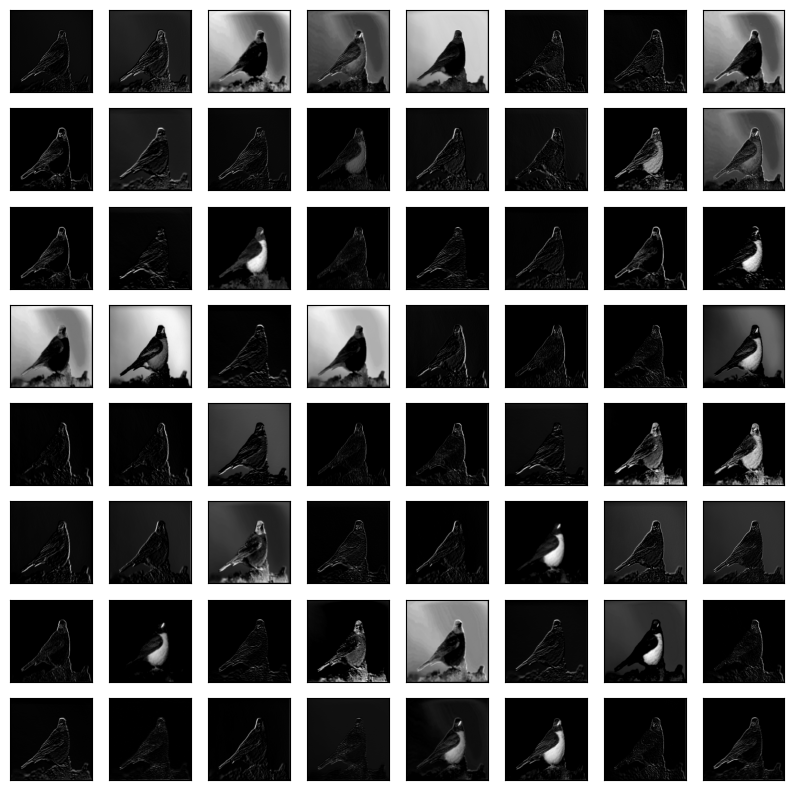

Visualization of the Feature Maps Extracted From Block 1 in the VGG16 Model






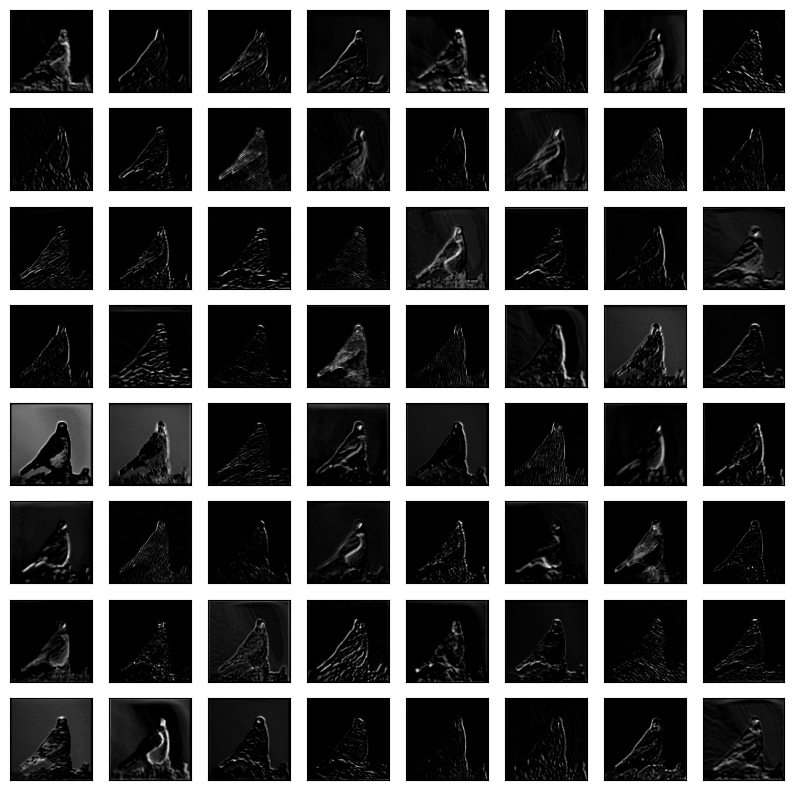

Visualization of the Feature Maps Extracted From Block 2 in the VGG16 Model






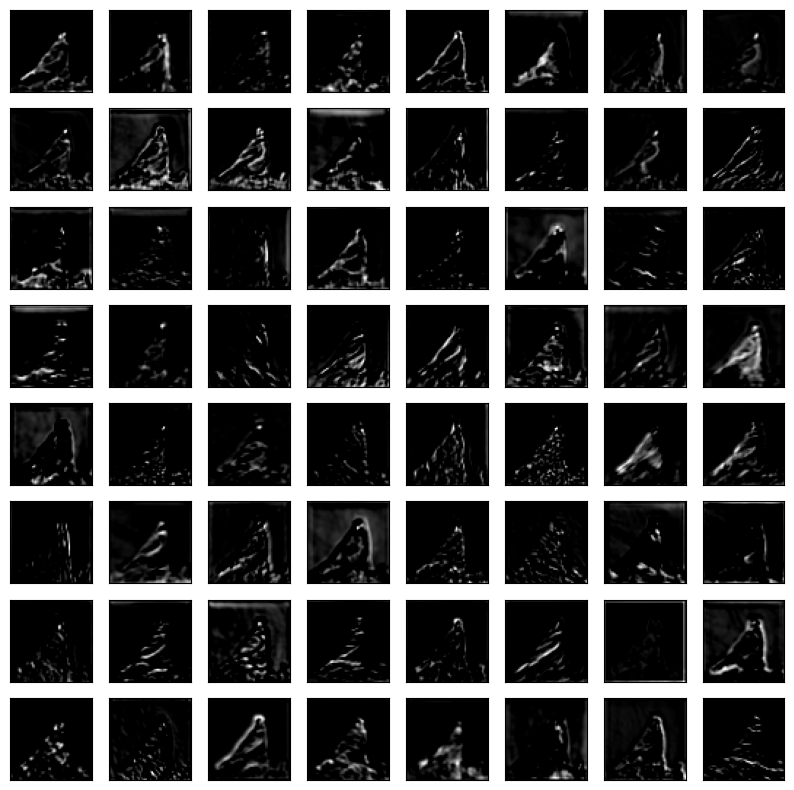

Visualization of the Feature Maps Extracted From Block 3 in the VGG16 Model






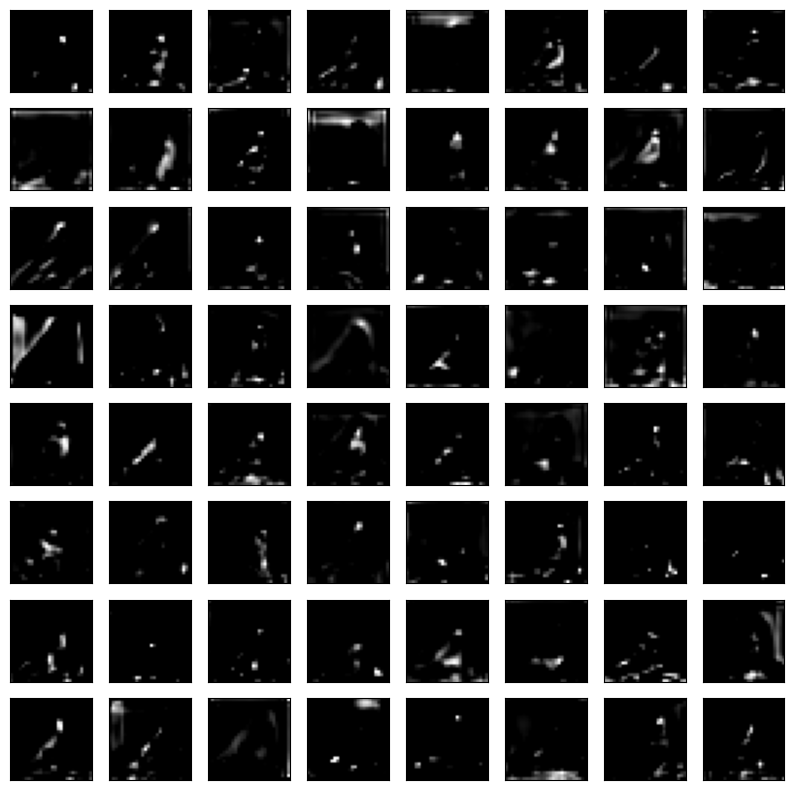

Visualization of the Feature Maps Extracted From Block 4 in the VGG16 Model






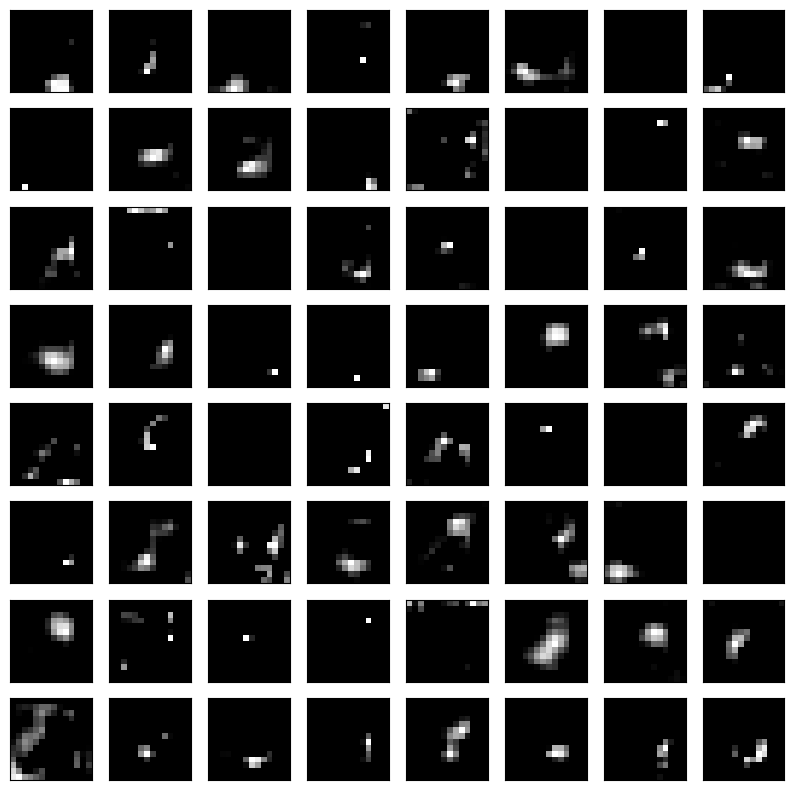

Visualization of the Feature Maps Extracted From Block 5 in the VGG16 Model






In [ ]:
square = 8
for num, fmap in enumerate(feature_maps, 1):
	# plot all 64 maps in an 8x8 squares
    ix = 1
    plt.figure(figsize=(10,10))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure

    pyplot.show()
    print("Visualization of the Feature Maps Extracted From Block {} in the VGG16 Model".format(num))
    print("\n\n\n")

- 모델 입력에 더 가까운 피처 맵이 이미지의 많은 세부 사항을 캡처하고 모델을 더 깊게 진행할수록 피처 맵이 점점 덜 세부적으로 표시됨을 알 수 있다.
- 모델이 이미지의 특징을 분류에 사용할 수 있는 보다 일반적인 개념으로 추상화하므로 이 패턴이 예상된다.
- 모델이 독수리를 본 것이 최종 이미지에서 명확하지 않지만 일반적으로 이러한 더 깊은 특징 맵을 해석하기는 어려워진다.